# TANG HAN KANG U2022842C

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Question 1: Part A

In [6]:
# Split data
#first remove fields that are not used
df.drop(columns=['full_address', 'nearest_stn'], inplace=True) #year is used for splitting dataset

train_dataframe = df.loc[df['year'] <= 2020]
val_dataframe = df.loc[df['year'] >= 2021]

#drop year column after splitting
train_dataframe = train_dataframe.drop(columns=['year'])
val_dataframe = val_dataframe.drop(columns=['year'])

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128) #prevent memory bottle neck

## Why split train/test chronologically instead of randomly?

A major assumption needed to be made for random train/test split is that each data sample is independent. However, resale_price value are heavily influenced by current market rate or past resale_prices. Hence random train/test split is not appropriate.

Using a chronological train/test split enables the model to learn the increasing trend of resale_price through the years.

# Question 1: Part B

## Modelling neural network

In [7]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

#encode as string
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")

#numeric features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")

all_inputs = [month,
              storey_range,
              flat_model_type,
              dist_to_nearest_stn,
              dist_to_dhoby,
              degree_centrality,
              eigenvector_centrality,
              remaining_lease_years,
              floor_area_sqm,]

# Encode Integer categorical features (one-hot)
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Encode String categorical features
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

# Encode Numerical features/standardisatioin
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

all_features = layers.concatenate([month_encoded,
                                  storey_range_encoded,
                                  flat_model_type_encoded,
                                  dist_to_nearest_stn_encoded,
                                  dist_to_dhoby_encoded,
                                  degree_centrality_encoded,
                                  eigenvector_centrality_encoded,
                                  remaining_lease_years_encoded,
                                  floor_area_sqm_encoded])
#building model from scratch
output = layers.Dense(1, activation="linear")(all_features)
model = keras.Model(all_inputs, output)
#model.compile(tf.keras.optimizers.Adam(0.001), "mse", metrics=['accuracy', r2])

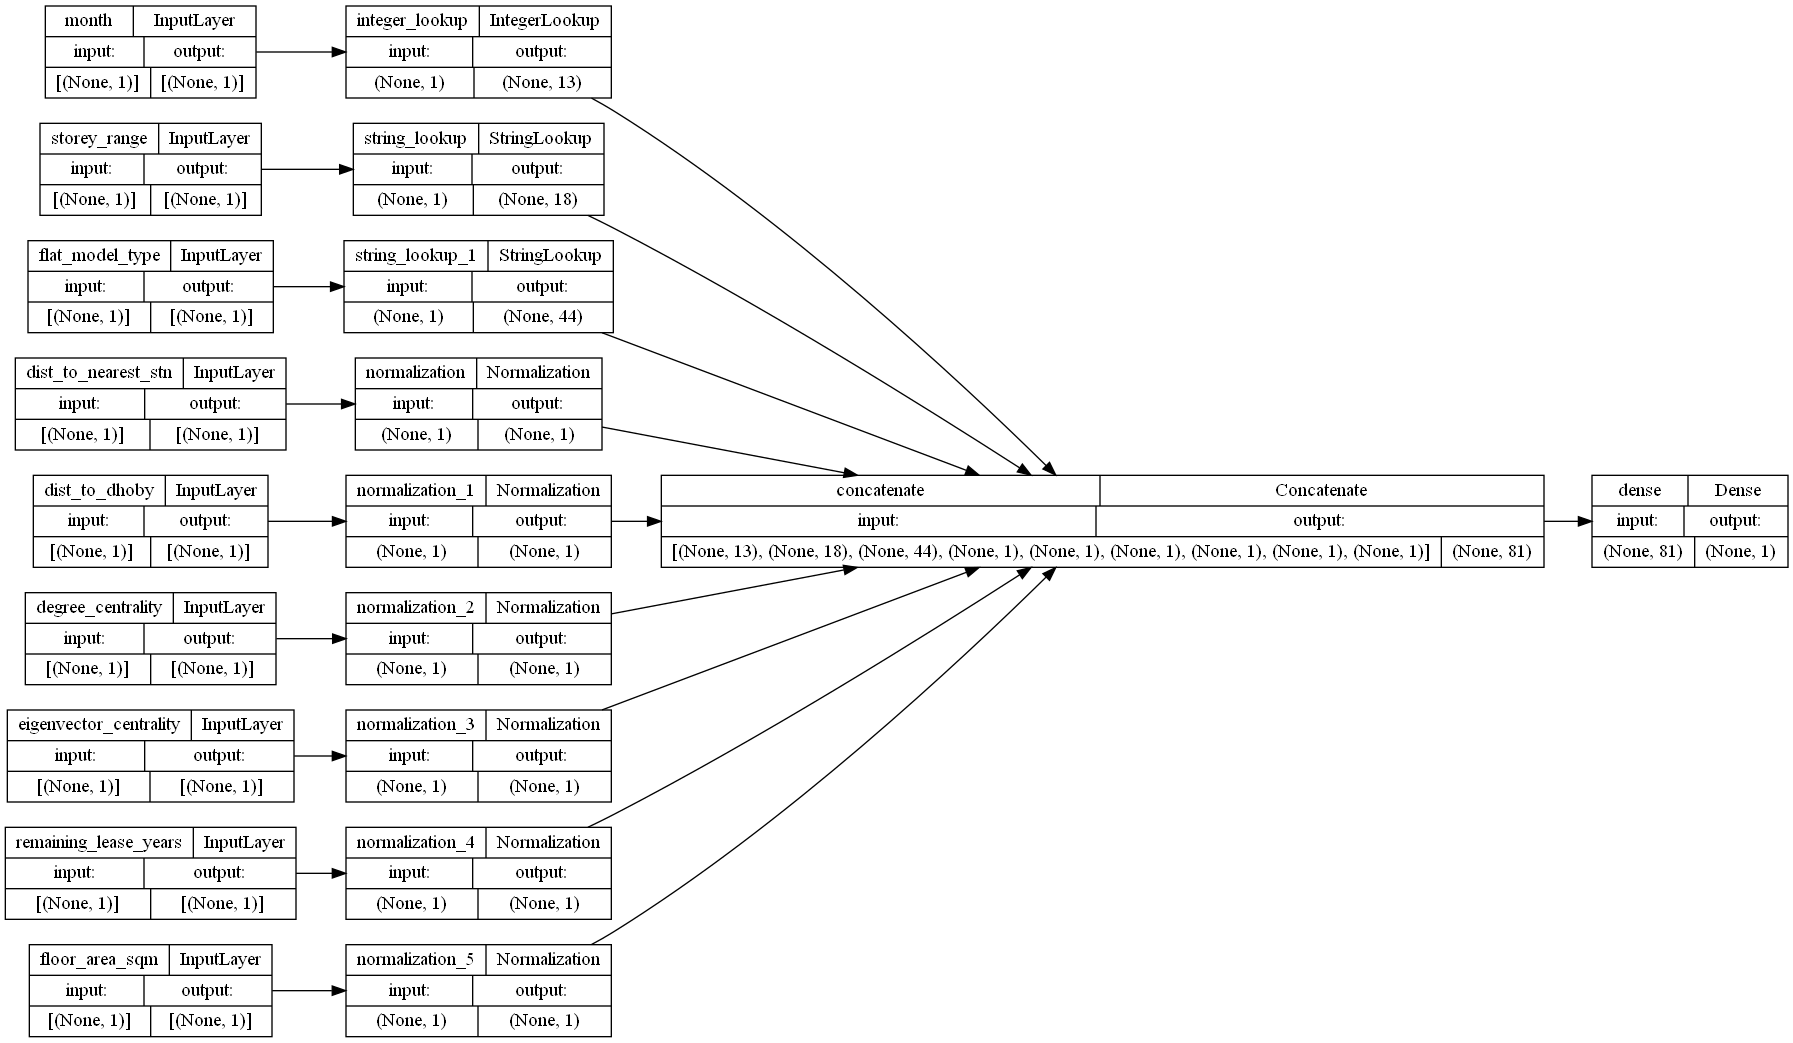

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, rankdir="LR")

# Question 1: Part C

The team suggests you to train the model for 50 epochs using mini-batch gradient
descent with batch size = 256, Adam optimiser (with a default learning rate of 𝛼 =
0.001) and mean square error as cost function. However, you find that your results
are far off from their model. Change the optimiser to SGD (with default learning rate
of 𝛼 = 0.01) and observe how the problem gets fixed. Report the test R
2 value and
explain why the change to SGD fixes the problem faced when using Adam optimiser.

## Results using Adam optimiser

In [9]:
model.compile(tf.keras.optimizers.Adam(0.001), "mse", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), r2])

history = model.fit(
    train_ds,
    batch_size=256,
    epochs=50,
    verbose=1,
    validation_data=val_ds,
    )

Epoch 1/50
683/683 [==============================] - 4s 4ms/step - loss: 219585445888.0000 - rmse: 468599.4375 - r2: -8.4602 - val_loss: 301485326336.0000 - val_rmse: 549076.8125 - val_r2: -10.2279
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 219582922752.0000 - rmse: 468596.7500 - r2: -8.4693 - val_loss: 301482377216.0000 - val_rmse: 549074.1250 - val_r2: -10.2229
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 219580170240.0000 - rmse: 468593.8125 - r2: -8.4812 - val_loss: 301479231488.0000 - val_rmse: 549071.2500 - val_r2: -10.2411
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 219577778176.0000 - rmse: 468591.2812 - r2: -8.4737 - val_loss: 301476249600.0000 - val_rmse: 549068.5000 - val_r2: -10.2286
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 219575173120.0000 - rmse: 468588.5000 - r2: -8.4645 - val_loss: 301473071104.0000 - val_rmse: 549065.6250 - val_r2: -10.2643
Epoch

683/683 [==============================] - 3s 4ms/step - loss: 219479457792.0000 - rmse: 468486.3438 - r2: -8.4430 - val_loss: 301360414720.0000 - val_rmse: 548963.0625 - val_r2: -10.2227
Epoch 43/50
683/683 [==============================] - 3s 4ms/step - loss: 219476951040.0000 - rmse: 468483.6875 - r2: -8.4666 - val_loss: 301357531136.0000 - val_rmse: 548960.4375 - val_r2: -10.1974
Epoch 44/50
683/683 [==============================] - 3s 4ms/step - loss: 219474378752.0000 - rmse: 468480.9375 - r2: -8.4656 - val_loss: 301354319872.0000 - val_rmse: 548957.5000 - val_r2: -10.2020
Epoch 45/50
683/683 [==============================] - 3s 4ms/step - loss: 219471724544.0000 - rmse: 468478.0938 - r2: -8.4658 - val_loss: 301351403520.0000 - val_rmse: 548954.8125 - val_r2: -10.2047
Epoch 46/50
683/683 [==============================] - 3s 4ms/step - loss: 219469119488.0000 - rmse: 468475.3125 - r2: -8.4599 - val_loss: 301348356096.0000 - val_rmse: 548952.0625 - val_r2: -10.2049
Epoch 47/50


In [10]:
lowest_error = np.argmin(history.history['val_loss'])
print("Test r^2 value for Adam optimiser: ", history.history['val_r2'][lowest_error])

Test r^2 value for Adam optimiser:  -10.19416332244873


## Results using SGD optimiser

In [11]:
model = keras.Model(all_inputs, output)
model.compile("SGD", "mse", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), r2])

history = model.fit(
    train_ds,
    batch_size=256,
    epochs=50,
    verbose=1,
    validation_data=val_ds,
    )

Epoch 1/50
683/683 [==============================] - 3s 4ms/step - loss: 12087496704.0000 - rmse: 109943.1484 - r2: 0.4768 - val_loss: 12907532288.0000 - val_rmse: 113611.3203 - val_r2: 0.5246
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 4907675136.0000 - rmse: 70054.8047 - r2: 0.7903 - val_loss: 12031176704.0000 - val_rmse: 109686.7188 - val_r2: 0.5560
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 4549385216.0000 - rmse: 67449.1328 - r2: 0.8058 - val_loss: 11659524096.0000 - val_rmse: 107979.2734 - val_r2: 0.5714
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 4348891136.0000 - rmse: 65946.1250 - r2: 0.8144 - val_loss: 11614636032.0000 - val_rmse: 107771.2188 - val_r2: 0.5724
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 4220145920.0000 - rmse: 64962.6484 - r2: 0.8196 - val_loss: 11389794304.0000 - val_rmse: 106722.9766 - val_r2: 0.5804
Epoch 6/50
683/683 [==================

683/683 [==============================] - 3s 4ms/step - loss: 3705735680.0000 - rmse: 60874.7539 - r2: 0.8410 - val_loss: 10492224512.0000 - val_rmse: 102431.5625 - val_r2: 0.6119
Epoch 44/50
683/683 [==============================] - 3s 4ms/step - loss: 3703626496.0000 - rmse: 60857.4258 - r2: 0.8412 - val_loss: 10705657856.0000 - val_rmse: 103468.1484 - val_r2: 0.6036
Epoch 45/50
683/683 [==============================] - 3s 4ms/step - loss: 3702088448.0000 - rmse: 60844.7891 - r2: 0.8409 - val_loss: 10629187584.0000 - val_rmse: 103097.9531 - val_r2: 0.6068
Epoch 46/50
683/683 [==============================] - 3s 4ms/step - loss: 3700277248.0000 - rmse: 60829.9023 - r2: 0.8409 - val_loss: 10467605504.0000 - val_rmse: 102311.3203 - val_r2: 0.6132
Epoch 47/50
683/683 [==============================] - 3s 4ms/step - loss: 3698899712.0000 - rmse: 60818.5820 - r2: 0.8411 - val_loss: 10397954048.0000 - val_rmse: 101970.3594 - val_r2: 0.6152
Epoch 48/50
683/683 [==========================

In [12]:
lowest_error = np.argmin(history.history['val_loss'])
print("Test r^2 value for SGD optimiser: ", history.history['val_r2'][lowest_error])

Test r^2 value for SGD optimiser:  0.6151915788650513


## Explain why?

When performing gradient descent, Adam optimiser may cause the model to overshoot or land in a non-global minima. This is the trade-off for faster convergence. Compared to Adam optimiser, SGD is more likely to converge at a global minima. 

# Question 1: Part D

## Built model with 1 more hidden layer

In [13]:
itmd = layers.Dense(10, activation="relu")(all_features) #using relu activation function to learn more complex function
output = layers.Dense(1, activation="linear")(itmd)
model = keras.Model(all_inputs, output)
model.compile(tf.keras.optimizers.Adam(0.08), "mse", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), r2])

history = model.fit(
    train_ds,
    batch_size=256,
    epochs=50,
    verbose=1,
    validation_data=val_ds,
    )

Epoch 1/50
683/683 [==============================] - 4s 4ms/step - loss: 161424785408.0000 - rmse: 401777.0312 - r2: -5.9429 - val_loss: 116778860544.0000 - val_rmse: 341729.2188 - val_r2: -3.3447
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 23244603392.0000 - rmse: 152461.8125 - r2: 0.0019 - val_loss: 16494510080.0000 - val_rmse: 128430.9531 - val_r2: 0.3934
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 5270020096.0000 - rmse: 72594.9062 - r2: 0.7753 - val_loss: 12138449920.0000 - val_rmse: 110174.6328 - val_r2: 0.5541
Epoch 4/50
683/683 [==============================] - 4s 5ms/step - loss: 4573559808.0000 - rmse: 67628.1016 - r2: 0.8050 - val_loss: 11704017920.0000 - val_rmse: 108185.1094 - val_r2: 0.5692
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 4199204096.0000 - rmse: 64801.2656 - r2: 0.8208 - val_loss: 11159865344.0000 - val_rmse: 105640.2656 - val_r2: 0.5887
Epoch 6/50
683/683 [============

Epoch 44/50
683/683 [==============================] - 3s 4ms/step - loss: 2580184576.0000 - rmse: 50795.5156 - r2: 0.8890 - val_loss: 9200523264.0000 - val_rmse: 95919.3594 - val_r2: 0.6569
Epoch 45/50
683/683 [==============================] - 3s 4ms/step - loss: 2572413696.0000 - rmse: 50718.9688 - r2: 0.8889 - val_loss: 9266629632.0000 - val_rmse: 96263.3359 - val_r2: 0.6552
Epoch 46/50
683/683 [==============================] - 3s 4ms/step - loss: 2563531264.0000 - rmse: 50631.3281 - r2: 0.8892 - val_loss: 9016232960.0000 - val_rmse: 94953.8438 - val_r2: 0.6645
Epoch 47/50
683/683 [==============================] - 3s 4ms/step - loss: 2554081024.0000 - rmse: 50537.9180 - r2: 0.8899 - val_loss: 8913288192.0000 - val_rmse: 94410.2109 - val_r2: 0.6691
Epoch 48/50
683/683 [==============================] - 3s 4ms/step - loss: 2545502720.0000 - rmse: 50452.9766 - r2: 0.8902 - val_loss: 9373768704.0000 - val_rmse: 96818.2266 - val_r2: 0.6514
Epoch 49/50
683/683 [========================

In [14]:
lowest_error = np.argmin(history.history['val_loss'])
print("Test r^2 value for Adam optimiser with additional hidden layer: ", history.history['val_r2'][lowest_error])

Test r^2 value for Adam optimiser with additional hidden layer:  0.6690709590911865


# Question 1: Part E

In the order of worst-performing to best-performing: Adam -> SGD -> linear regression -> Adam with 1 hidden layer

The first two models did not perform better than linear regression because they were made to replicate a linear regression model, and did not capitalise on the advantages of using a neural network mode. Adam optimiser with 1 hidden layer reap the advantages of a trained neural network, and was able to perform better than linear regression (traditional machine learning model). With the additionial layer of 10 neurons, the model in Q1D) can learn more information from the dataset compared to linear regression model.

# Question 2: Part A

## Further split train set

In [8]:
train_dataframe = df.loc[df['year'] < 2020]
val_dataframe = df.loc[df['year'] == 2020]

#drop year column after splitting
train_dataframe = train_dataframe.drop(columns=['year'])
val_dataframe = val_dataframe.drop(columns=['year'])

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

# Question 2: Part B

## Embedding layer

In [9]:
#define helper function
from math import floor

def encode_categorical_feature_2(feature, name, dataset, is_string, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") 
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)
    
    #find the num of categories
    encoded_feature = lookup(feature)
    num_categories = len(lookup.get_vocabulary())
    encoded_feature = layers.Embedding(num_categories, floor(num_categories/divisor))(encoded_feature) #embed features
    encoded_feature_flat = layers.Flatten()(encoded_feature) #adding flatten later

    return encoded_feature_flat

# Question 2: Part C

## Parameter search

In [10]:
#importing libraries
import keras_tuner as kt

In [11]:
#define helper functions
def call_existing_code(units, lr, divisor):
    # Encode Integer categorical features
    month_encoded = encode_categorical_feature_2(month, "month", train_ds, False, divisor)

    # Encode String categorical features
    storey_range_encoded = encode_categorical_feature_2(storey_range, "storey_range", train_ds, True, divisor)
    flat_model_type_encoded = encode_categorical_feature_2(flat_model_type, "flat_model_type", train_ds, True, divisor)

    # Encode Numerical features/standardisatioin
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    all_features = layers.concatenate([month_encoded,
                                      storey_range_encoded,
                                      flat_model_type_encoded,
                                      dist_to_nearest_stn_encoded,
                                      dist_to_dhoby_encoded,
                                      degree_centrality_encoded,
                                      eigenvector_centrality_encoded,
                                      remaining_lease_years_encoded,
                                      floor_area_sqm_encoded])
    
    itmd = layers.Dense(units = units, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(itmd)
    model = keras.Model(all_inputs, output)
    model.compile(tf.keras.optimizers.Adam(lr), "mse", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), r2])
    return model


def build_model(hp):
    units = hp.Int("units", min_value=4, max_value=32, step=4)
    lr = hp.Float("lr", min_value=1e-4, max_value=2e-1, sampling="log")
    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)
    # call existing model-building code with the hyperparameter values.
    model = call_existing_code(
        units = units, lr = lr, divisor = divisor
    )
    return model

In [12]:
build_model(kt.HyperParameters())
#start the parameter search
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=10,
    overwrite = False
) #overwrite stops the function from replacing previous tuned results

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(train_ds,
             batch_size = 256,
             epochs = 50,
             verbose = 1,
             validation_data=val_ds,
             callbacks=[callback])


INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


# Question 2: Part D

## Train model with best configuration

In [33]:
#reset train_dataframe and val_dataframe
train_dataframe = df.loc[df['year'] <= 2020]
val_dataframe = df.loc[df['year'] >= 2021]

#drop year column after splitting
train_dataframe = train_dataframe.drop(columns=['year'])
val_dataframe = val_dataframe.drop(columns=['year'])

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128) #prevent memory bottle neck

In [34]:
#model checkpoint call back for saving weights of best epoch
checkpoint_filepath = './tmp/checkpoint.{epoch:02d}'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [35]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)
#use train_ds and val_ds
history = model.fit(train_ds,
                   batch_size = 256,
                   epochs = 50,
                   verbose = 1,
                   validation_data = val_ds,
                   callbacks=[callback, model_checkpoint_callback])

Epoch 1/50
683/683 [==============================] - 5s 5ms/step - loss: 19201978368.0000 - rmse: 138571.2031 - r2: 0.1768 - val_loss: 12062167040.0000 - val_rmse: 109827.8984 - val_r2: 0.5550
Epoch 2/50
683/683 [==============================] - 4s 6ms/step - loss: 4830028800.0000 - rmse: 69498.4062 - r2: 0.7933 - val_loss: 9659970560.0000 - val_rmse: 98285.1484 - val_r2: 0.6434
Epoch 3/50
683/683 [==============================] - 5s 7ms/step - loss: 4101069056.0000 - rmse: 64039.5898 - r2: 0.8240 - val_loss: 8771517440.0000 - val_rmse: 93656.3828 - val_r2: 0.6754
Epoch 4/50
683/683 [==============================] - 6s 8ms/step - loss: 3890711040.0000 - rmse: 62375.5625 - r2: 0.8330 - val_loss: 10620539904.0000 - val_rmse: 103056.0000 - val_r2: 0.6065
Epoch 5/50
683/683 [==============================] - 6s 7ms/step - loss: 3816080128.0000 - rmse: 61774.4297 - r2: 0.8363 - val_loss: 8637826048.0000 - val_rmse: 92939.9062 - val_r2: 0.6807
Epoch 6/50
683/683 [========================

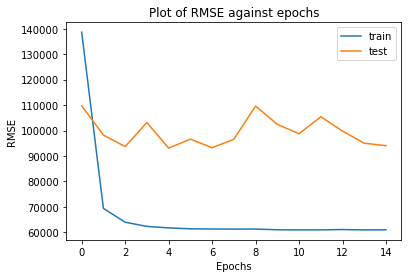

In [50]:
# Plotting the Model RMSE
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Plot of RMSE against epochs')
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='best')

# Question 2: Part E

## Test R^2 value

The last model configuration saved is for epoch 05 as seen from the names of the checkpoint files. It also matches the training summary in Q2d). 

In [36]:
print("The test R^2 value is ", history.history['val_r2'][4])

The test R^2 value is  0.6807291507720947


## Model from the best epoch

In [37]:
#load model from best epoch
model.load_weights("./tmp/checkpoint.05")

In [38]:
#reset val dataset to change batch size to encapsulate every validation data
val_ds = dataframe_to_dataset(val_dataframe)
val_ds = val_ds.batch(len(val_dataframe)) #combine entire val_dataset into one batch
test = list(val_ds.as_numpy_iterator())

In [39]:
#use best model to predict on validation data set
predicted_value = model.predict(test[0][0]).flatten()
actual_value = test[0][1].flatten()

1439/1439 [==============================] - 5s 3ms/step


In [40]:
#remake dataframe to combine X_test, predicted, and actual
df_combined = pd.DataFrame(data={
    'month':test[0][0]['month'],
    'dist_to_nearest_stn':test[0][0]['dist_to_nearest_stn'],
    'dist_to_dhoby':test[0][0]['dist_to_dhoby'],
    'degree_centrality':test[0][0]['degree_centrality'],
    'eigenvector_centrality':test[0][0]['eigenvector_centrality'],
    'flat_model_type':test[0][0]['flat_model_type'],
    'remaining_lease_years':test[0][0]['remaining_lease_years'],
    'floor_area_sqm':test[0][0]['floor_area_sqm'],
    'storey_range':test[0][0]['storey_range'],
    'predicted': predicted_value,
    'actual': actual_value
})

In [41]:
df_combined

,month,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,predicted,actual
0,7,1.695447,11.485393,0.016807,0.000233,"b'3 ROOM, Model A'",93.250000,68.0,b'19 TO 21',418454.31250,443000.0
1,1,0.384294,14.021843,0.016807,0.000127,"b'5 ROOM, Improved'",71.750000,124.0,b'07 TO 09',506249.81250,530000.0
2,3,1.012238,10.460310,0.016807,0.001507,"b'4 ROOM, DBSS'",91.750000,92.0,b'13 TO 15',629359.25000,688000.0
3,12,0.584565,13.923292,0.008403,0.000079,"b'EXECUTIVE, Apartment'",70.750000,145.0,b'10 TO 12',603460.81250,780000.0
4,8,0.388055,4.083001,0.016807,0.008342,"b'5 ROOM, Premium Apartment'",94.083333,108.0,b'04 TO 06',701148.06250,930000.0
...,...,...,...,...,...,...,...,...,...,...,...
46037,11,0.941644,14.081317,0.016807,0.000216,"b'3 ROOM, Model A'",60.583333,74.0,b'04 TO 06',246707.34375,317000.0
46038,1,1.362620,13.266558,0.008403,0.000070,"b'4 ROOM, Model A'",94.000000,92.0,b'16 TO 18',444280.68750,455000.0
46039,7,0.667832,11.455130,0.016807,0.000233,"b'4 ROOM, Model A'",77.500000,102.0,b'10 TO 12',472699.21875,445000.0
46040,9,0.294347,16.650206,0.016807,0.000150,"b'5 ROOM, Premium Apartment'",78.750000,111.0,b'13 TO 15',466394.65625,548000.0


In [42]:
#insert absolute error into df
df_combined["absolute_error"] = df_combined.apply(lambda x: abs(x.predicted-x.actual), axis=1)

In [43]:
#sort by absolute error in descending order
df_combined.sort_values(by=['absolute_error'], ascending = False, inplace = True)

## Show top 30 test samples with largest errors

In [44]:
df_combined.head(30)

,month,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,predicted,actual,absolute_error
19824,12,0.428356,8.948410,0.016807,0.001358,"b'EXECUTIVE, Maisonette'",66.666667,154.0,b'04 TO 06',760174.3125,1238000.0,477825.6875
42729,8,0.489478,3.977493,0.016807,0.008342,"b'5 ROOM, Premium Apartment'",93.083333,104.0,b'13 TO 15',705312.9375,1181000.0,475687.0625
11186,4,0.245502,9.313260,0.016807,0.001179,"b'5 ROOM, Improved'",95.333333,112.0,b'22 TO 24',718372.9375,1188000.0,469627.0625
26455,5,0.586629,2.932814,0.016807,0.047782,"b'5 ROOM, Improved'",96.083333,113.0,b'40 TO 42',935155.5625,1400000.0,464844.4375
28721,1,0.271583,9.003026,0.016807,0.001358,"b'EXECUTIVE, Maisonette'",65.666667,146.0,b'07 TO 09',751902.2500,1202000.0,450097.7500
21985,12,0.473544,8.936025,0.016807,0.001358,"b'EXECUTIVE, Apartment'",66.750000,142.0,b'04 TO 06',682024.5000,1125000.0,442975.5000
32223,7,1.216557,8.071776,0.016807,0.006243,"b'EXECUTIVE, Apartment'",72.833333,146.0,b'04 TO 06',684082.3125,1120000.0,435917.6875
948,5,0.586629,2.932814,0.016807,0.047782,"b'5 ROOM, Improved'",96.083333,113.0,b'46 TO 48',946613.3750,1380000.0,433386.6250
9000,3,0.271583,9.003026,0.016807,0.001358,"b'EXECUTIVE, Maisonette'",65.500000,146.0,b'13 TO 15',764971.8125,1198000.0,433028.1875
12076,8,0.504800,5.727076,0.016807,0.010276,"b'5 ROOM, Model A'",73.166667,138.0,b'07 TO 09',697178.3750,1128000.0,430821.6250


## Trends observed and suggestions

From the top 30 test samples, one of the observed trend is the flat model type. A large majority of these records have flat_model_type of "5 ROOM..." or "EXECUTIVE...". Another trend that can be observed is that majority of the actual resale prices of these thirty flats are above the one million dollar mark. These observations lead me to believe that such flat models with higher-end resale prices should fall into a separate category and hence have a model trained specifically for them. These will in turn reduce the errors.

# Q3: Part A

## Apply model from 2d) on old test set

In [47]:
#old test set split
#extract df from ‘HDB_price_prediction_old.csv’
df_old = pd.read_csv('hdb_price_prediction_old.csv')

# Split data
#first remove fields that are not used
df_old.drop(columns=['full_address', 'nearest_stn'], inplace=True) #year is used for splitting dataset

#val_dataframe extraction
val_dataframe = df_old.loc[df['year'] >= 2021] #up till Aug 2021

#drop year column after splitting
val_dataframe = val_dataframe.drop(columns=['year'])

val_ds = dataframe_to_dataset(val_dataframe)

val_ds = val_ds.batch(len(val_dataframe)) #combine entire val_dataset into one batch

test = list(val_ds.as_numpy_iterator())[0]

In [52]:
#use best model to predict on validation data set
predicted_value = model.predict(test[0]).flatten() #flatten into 1D array
actual_value = test[1].flatten() #flatten into 1D array

523/523 [==============================] - 2s 3ms/step


In [61]:
# convert it to tensorflow object
actual_tensor = tf.convert_to_tensor(actual_value)
actual_tensor = tf.cast(actual_tensor, dtype=tf.float32) # r2 function requires float32 tensor
predicted_tensor = tf.convert_to_tensor(predicted_value)
predicted_tensor = tf.cast(predicted_tensor, dtype=tf.float32) # r2 function requires float32 tensor

In [63]:
#calculate test r^2 value
r2_old = r2(actual_tensor, predicted_tensor)

In [68]:
print("The test R2 value for old test set is", tf.get_static_value(r2_old))

The test R2 value for old test set is 0.8059886


## Apply model from 2d) on new test set (2021 split)

In [69]:
#new test set split (2021)
#extract df from ‘HDB_price_prediction.csv’
df_new_2021 = pd.read_csv('hdb_price_prediction.csv')

# Split data
#first remove fields that are not used
df_new_2021.drop(columns=['full_address', 'nearest_stn'], inplace=True) #year is used for splitting dataset

#val_dataframe extraction
val_dataframe = df_new_2021.loc[df['year'] == 2021] #up till end 2021

#drop year column after splitting
val_dataframe = val_dataframe.drop(columns=['year'])

val_ds = dataframe_to_dataset(val_dataframe)

val_ds = val_ds.batch(len(val_dataframe)) #combine entire val_dataset into one batch

test = list(val_ds.as_numpy_iterator())[0]

In [70]:
#use best model to predict on validation data set
predicted_value = model.predict(test[0]).flatten()
actual_value = test[1].flatten()

909/909 [==============================] - 3s 4ms/step


In [71]:
# convert it to tensorflow object
actual_tensor = tf.convert_to_tensor(actual_value)
actual_tensor = tf.cast(actual_tensor, dtype=tf.float32) # r2 function requires float32 tensor
predicted_tensor = tf.convert_to_tensor(predicted_value)
predicted_tensor = tf.cast(predicted_tensor, dtype=tf.float32)

In [72]:
# convert it to tensorflow object
actual_tensor = tf.convert_to_tensor(actual_value)
actual_tensor = tf.cast(actual_tensor, dtype=tf.float32) # r2 function requires float32 tensor
predicted_tensor = tf.convert_to_tensor(predicted_value)
predicted_tensor = tf.cast(predicted_tensor, dtype=tf.float32)

In [73]:
#calculate test r^2 value
r2_new_2021 = r2(actual_tensor, predicted_tensor)

print("The test R2 value for old test set is", tf.get_static_value(r2_new_2021))

The test R2 value for old test set is 0.7690668


## Apply model from 2d) on new test set (2022 split)

In [74]:
#new test set split (2022)
#extract df from ‘HDB_price_prediction.csv’
df_new_2022 = pd.read_csv('hdb_price_prediction.csv')

# Split data
#first remove fields that are not used
df_new_2022.drop(columns=['full_address', 'nearest_stn'], inplace=True) #year is used for splitting dataset

#val_dataframe extraction
val_dataframe = df_new_2022.loc[df['year'] == 2022] #only 2022

#drop year column after splitting
val_dataframe = val_dataframe.drop(columns=['year'])

val_ds = dataframe_to_dataset(val_dataframe)

val_ds = val_ds.batch(len(val_dataframe)) #combine entire val_dataset into one batch

test = list(val_ds.as_numpy_iterator())[0]

In [75]:
#use best model to predict on validation data set
predicted_value = model.predict(test[0]).flatten()
actual_value = test[1].flatten()

531/531 [==============================] - 2s 3ms/step


In [76]:
# convert it to tensorflow object
actual_tensor = tf.convert_to_tensor(actual_value)
actual_tensor = tf.cast(actual_tensor, dtype=tf.float32) # r2 function requires float32 tensor
predicted_tensor = tf.convert_to_tensor(predicted_value)
predicted_tensor = tf.cast(predicted_tensor, dtype=tf.float32)

In [77]:
#calculate test r^2 value
r2_new_2022 = r2(actual_tensor, predicted_tensor)

print("The test R2 value for old test set is", tf.get_static_value(r2_new_2022))

The test R2 value for old test set is 0.5492594


# Question 3: Part B

For the team's model, the extent of the decrease in r^2 is greater when compared to my model. This also indicates that their model suffers a higher degree of model degradation. However, since both models experience a decrease in r^2 values, both models have succumbed to model degradation. The additional layer in my model may have picked up trends and patterns that were not picked up by the machine learning methodology employed by the team. However, this does not prevent concept drifting from happening, hence we can observe a decrease in r^2 value.

# Question 3: Part C

## Largest covariate/label shift

In [119]:
#create list of features
ft_numeric = ['remaining_lease_years']

After analysing the plots for all the features, I've removed features that showed no substantial covariate/label shift, so that subsequent code will only plot for features that display relatively larger covariate/label shift. The categoric data has been removed from subsequent studies since it did not show obvious distribution shift.

In [120]:
# reset df to contain all values
df_new = pd.read_csv('hdb_price_prediction.csv')

#first remove fields that are not used
df_new.drop(columns=['full_address', 'nearest_stn'], inplace=True) #year is used for splitting dataset

#subset of the dataframe where I want to study the concept shift
train_dataframe = df_new.loc[df['year'] <= 2020] #training set before y2021
val_dataframe_2021 = df_new.loc[df['year'] == 2021] #validation set of y2021
val_dataframe_2022 = df_new.loc[df['year'] == 2022] #validation set of y2022

In [121]:
import seaborn as sns

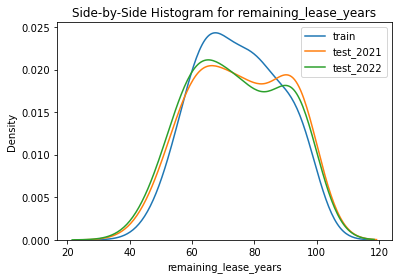

In [122]:
#kde plots for each numeric features
for ft in ft_numeric:
    fig, ax = plt.subplots()
    sns.kdeplot(train_dataframe[ft], bw_method=0.5, ax = ax, label='train')
    sns.kdeplot(val_dataframe_2021[ft], bw_method=0.5, ax = ax, label='test_2021')
    sns.kdeplot(val_dataframe_2022[ft], bw_method=0.5, ax = ax, label='test_2022')
    plt.title('Side-by-Side Histogram for '+ft)
    plt.legend()

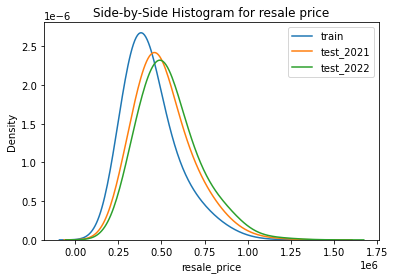

In [118]:
#kde plot for resale_price
fig, ax = plt.subplots()
sns.kdeplot(train_dataframe['resale_price'], bw_method=0.5, ax = ax, label='train')
sns.kdeplot(val_dataframe_2021['resale_price'], bw_method=0.5, ax = ax, label='test_2021')
sns.kdeplot(val_dataframe_2022['resale_price'], bw_method=0.5, ax = ax, label='test_2022')
plt.title('Side-by-Side Histogram for resale price')
plt.legend()

From what I observe, the target to predict, 'resale_price', and 'remaining_lease_years' feature show the largest label/covariate shift.

## Suggestion for tackling model degradation

As observed from the above plots, 'resale_price' density plot is shifting to the right with each year of data. The density plot for 'remaining_lease_years' also varies yearly. Hence, in order to address the problem of model degradation, the trained model should be reviewed on a yearly basis. During the review, if r^2 value falls below an acceptable threshold, the model will need to be retrained in order to account for information introduced by new data.

# Question 3: Part D

## Finding ideal subset of features using RFE.py

In [13]:
best_hps=tuner.get_best_hyperparameters()[0]
units = best_hps.get('units')
lr = best_hps.get('lr')
divisor = best_hps.get('divisor')

In [17]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)


import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])
    
    # TODO: define the input layer here (your code from Q2)
    
    df = pd.read_csv('hdb_price_prediction.csv')
    
    # Split data
    #first remove fields that are not used
    df.drop(columns=['full_address', 'nearest_stn'], inplace=True) #year is used for splitting dataset

    train_dataframe = df.loc[df['year'] <= 2020]
    val_dataframe = df.loc[df['year'] >= 2021]

    #drop year column after splitting
    train_dataframe = train_dataframe.drop(columns=['year'])
    val_dataframe = val_dataframe.drop(columns=['year'])

    train_ds = dataframe_to_dataset(train_dataframe)
    val_ds = dataframe_to_dataset(val_dataframe)

    train_ds = train_ds.batch(128)
    val_ds = val_ds.batch(128) #prevent memory bottle neck
    
    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")

    #encode as string
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")

    #numeric features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    
     # Encode Integer categorical features
    month_encoded = encode_categorical_feature_2(month, "month", train_ds, False, divisor)

    # Encode String categorical features
    storey_range_encoded = encode_categorical_feature_2(storey_range, "storey_range", train_ds, True, divisor)
    flat_model_type_encoded = encode_categorical_feature_2(flat_model_type, "flat_model_type", train_ds, True, divisor)

    # Encode Numerical features/standardisatioin
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

    all_features_input = [month_encoded,
                  storey_range_encoded,
                  flat_model_type_encoded,
                  dist_to_nearest_stn_encoded,
                  dist_to_dhoby_encoded,
                  degree_centrality_encoded,
                  eigenvector_centrality_encoded,
                  remaining_lease_years_encoded,
                  floor_area_sqm_encoded]
    
    all_inputs = [month,
                  storey_range,
                  flat_model_type,
                  dist_to_nearest_stn,
                  dist_to_dhoby,
                  degree_centrality,
                  eigenvector_centrality,
                  remaining_lease_years,
                  floor_area_sqm]
    
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    
    # Build the model
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    itmd = layers.Dense(units = units, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(itmd)
    model = keras.Model(all_inputs, output)
    model.compile(tf.keras.optimizers.Adam(lr), "mse", metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), r2])
    
    history = model.fit(train_ds,
                       batch_size = 256,
                       epochs = 50,
                       verbose = 1,
                       validation_data = val_ds,
                       callbacks=[callback])
    
    val_loss_hx = history.history["val_rmse"]
    val_loss_min = min(val_loss_hx) #epoch with min loss
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)


vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]
going through feature_mask [0, 1, 1, 1, 1, 1, 1, 1, 1]
Skipping KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name=None), name='flatten_12/Reshape:0', description="created by layer 'flatten_12'")
KerasTensor(type_spec=TensorSpec(shape=(None, 9), dtype=tf.float32, name=None), name='flatten_13/Reshape:0', description="created by layer 'flatten_13'")
KerasTensor(type_spec=TensorSpec(shape=(None, 22), dtype=tf.float32, name=None), name='flatten_14/Reshape:0', description="created by layer 'flatten_14'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_30/truediv:0', description="created by layer 'normalization_30'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='normalization_31/truediv:0', description="created by layer 'normalization_31'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype

Epoch 6/50
683/683 [==============================] - 3s 4ms/step - loss: 4437958656.0000 - rmse: 66618.0078 - r2: 0.8100 - val_loss: 11851491328.0000 - val_rmse: 108864.5547 - val_r2: 0.5630
Epoch 7/50
683/683 [==============================] - 3s 4ms/step - loss: 4404738560.0000 - rmse: 66368.2031 - r2: 0.8111 - val_loss: 10633992192.0000 - val_rmse: 103121.2500 - val_r2: 0.6068
Epoch 8/50
683/683 [==============================] - 3s 4ms/step - loss: 4397957632.0000 - rmse: 66317.1016 - r2: 0.8117 - val_loss: 10826701824.0000 - val_rmse: 104051.4375 - val_r2: 0.6006
Epoch 9/50
683/683 [==============================] - 3s 4ms/step - loss: 4408121344.0000 - rmse: 66393.6875 - r2: 0.8109 - val_loss: 12236626944.0000 - val_rmse: 110619.2891 - val_r2: 0.5475
Epoch 10/50
683/683 [==============================] - 3s 4ms/step - loss: 4400395264.0000 - rmse: 66335.4766 - r2: 0.8110 - val_loss: 12415527936.0000 - val_rmse: 111424.9844 - val_r2: 0.5407
Epoch 11/50
683/683 [==================

683/683 [==============================] - 4s 4ms/step - loss: 20071364608.0000 - rmse: 141673.4375 - r2: 0.1436 - val_loss: 12866405376.0000 - val_rmse: 113430.1797 - val_r2: 0.5253
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 6865582592.0000 - rmse: 82858.8125 - r2: 0.7064 - val_loss: 14221546496.0000 - val_rmse: 119254.1250 - val_r2: 0.4746
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 6700810240.0000 - rmse: 81858.4766 - r2: 0.7128 - val_loss: 14548878336.0000 - val_rmse: 120618.7344 - val_r2: 0.4615
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 6664910336.0000 - rmse: 81638.8984 - r2: 0.7139 - val_loss: 12328580096.0000 - val_rmse: 111034.1406 - val_r2: 0.5445
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 6612227072.0000 - rmse: 81315.6016 - r2: 0.7160 - val_loss: 12227968000.0000 - val_rmse: 110580.1406 - val_r2: 0.5478
Epoch 6/50
683/683 [=============================

683/683 [==============================] - 3s 4ms/step - loss: 4479714304.0000 - rmse: 66930.6641 - r2: 0.8067 - val_loss: 11312129024.0000 - val_rmse: 106358.4922 - val_r2: 0.5808
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 4465857024.0000 - rmse: 66827.0703 - r2: 0.8082 - val_loss: 9536492544.0000 - val_rmse: 97654.9688 - val_r2: 0.6468
Epoch 6/50
683/683 [==============================] - 3s 4ms/step - loss: 4435009536.0000 - rmse: 66595.8672 - r2: 0.8097 - val_loss: 9737133056.0000 - val_rmse: 98676.9141 - val_r2: 0.6398
Epoch 7/50
683/683 [==============================] - 3s 4ms/step - loss: 4430127104.0000 - rmse: 66559.2031 - r2: 0.8094 - val_loss: 10829293568.0000 - val_rmse: 104063.8906 - val_r2: 0.5985
Epoch 8/50
683/683 [==============================] - 3s 4ms/step - loss: 4453144064.0000 - rmse: 66731.8828 - r2: 0.8087 - val_loss: 12148017152.0000 - val_rmse: 110218.0469 - val_r2: 0.5498
Epoch 9/50
683/683 [==============================] - 3

Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 5091323904.0000 - rmse: 71353.5156 - r2: 0.7818 - val_loss: 12423570432.0000 - val_rmse: 111461.0703 - val_r2: 0.5416
Epoch 6/50
683/683 [==============================] - 3s 4ms/step - loss: 5069655040.0000 - rmse: 71201.5078 - r2: 0.7827 - val_loss: 11418769408.0000 - val_rmse: 106858.6406 - val_r2: 0.5784
Epoch 7/50
683/683 [==============================] - 3s 4ms/step - loss: 5041675776.0000 - rmse: 71004.7578 - r2: 0.7838 - val_loss: 11627185152.0000 - val_rmse: 107829.4297 - val_r2: 0.5711
Epoch 8/50
683/683 [==============================] - 3s 4ms/step - loss: 5052287488.0000 - rmse: 71079.4453 - r2: 0.7839 - val_loss: 10253761536.0000 - val_rmse: 101260.8594 - val_r2: 0.6214
Epoch 9/50
683/683 [==============================] - 3s 4ms/step - loss: 5036860416.0000 - rmse: 70970.8438 - r2: 0.7842 - val_loss: 11071395840.0000 - val_rmse: 105220.7031 - val_r2: 0.5912
Epoch 10/50
683/683 [===================

683/683 [==============================] - 4s 4ms/step - loss: 20663857152.0000 - rmse: 143749.2812 - r2: 0.1131 - val_loss: 12891053056.0000 - val_rmse: 113538.7734 - val_r2: 0.5247
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 7643353088.0000 - rmse: 87426.2734 - r2: 0.6725 - val_loss: 13711654912.0000 - val_rmse: 117096.7734 - val_r2: 0.4946
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 7505755136.0000 - rmse: 86635.7578 - r2: 0.6777 - val_loss: 16806898688.0000 - val_rmse: 129641.4219 - val_r2: 0.3784
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 7465505792.0000 - rmse: 86403.1562 - r2: 0.6802 - val_loss: 13148397568.0000 - val_rmse: 114666.4609 - val_r2: 0.5136
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 7443375616.0000 - rmse: 86275.0000 - r2: 0.6804 - val_loss: 14066752512.0000 - val_rmse: 118603.3438 - val_r2: 0.4804
Epoch 6/50
683/683 [=============================

683/683 [==============================] - 4s 4ms/step - loss: 20091736064.0000 - rmse: 141745.3281 - r2: 0.1465 - val_loss: 11475017728.0000 - val_rmse: 107121.5078 - val_r2: 0.5776
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 5529581568.0000 - rmse: 74361.1562 - r2: 0.7628 - val_loss: 11208054784.0000 - val_rmse: 105868.1016 - val_r2: 0.5843
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 4603590144.0000 - rmse: 67849.7578 - r2: 0.8022 - val_loss: 10744267776.0000 - val_rmse: 103654.5625 - val_r2: 0.6026
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 4487010304.0000 - rmse: 66985.1484 - r2: 0.8075 - val_loss: 12196503552.0000 - val_rmse: 110437.7812 - val_r2: 0.5491
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 4437632000.0000 - rmse: 66615.5547 - r2: 0.8093 - val_loss: 13027268608.0000 - val_rmse: 114137.0625 - val_r2: 0.5171
Epoch 6/50
683/683 [=============================

683/683 [==============================] - 4s 4ms/step - loss: 19540549632.0000 - rmse: 139787.5156 - r2: 0.1667 - val_loss: 12248321024.0000 - val_rmse: 110672.1328 - val_r2: 0.5474
Epoch 2/50
683/683 [==============================] - 3s 4ms/step - loss: 5719138304.0000 - rmse: 75624.9844 - r2: 0.7547 - val_loss: 9890176000.0000 - val_rmse: 99449.3672 - val_r2: 0.6337
Epoch 3/50
683/683 [==============================] - 3s 4ms/step - loss: 5088245760.0000 - rmse: 71331.9375 - r2: 0.7816 - val_loss: 11074733056.0000 - val_rmse: 105236.5547 - val_r2: 0.5905
Epoch 4/50
683/683 [==============================] - 3s 4ms/step - loss: 4933652992.0000 - rmse: 70239.9688 - r2: 0.7885 - val_loss: 9447736320.0000 - val_rmse: 97199.4688 - val_r2: 0.6511
Epoch 5/50
683/683 [==============================] - 3s 4ms/step - loss: 4900713472.0000 - rmse: 70005.0938 - r2: 0.7892 - val_loss: 12607663104.0000 - val_rmse: 112283.8516 - val_r2: 0.5341
Epoch 6/50
683/683 [==============================] -

In [19]:
print("min loss vec: [1, 1, 1, 0, 1, 1, 1, 1, 1]") #based on arg_min(all_losses)

min loss vec: [1, 1, 1, 0, 1, 1, 1, 1, 1]


Therefore, the best feature subset is [month,
                  storey_range,
                  flat_model_type,
                  dist_to_dhoby,
                  degree_centrality,
                  eigenvector_centrality,
                  remaining_lease_years,
                  floor_area_sqm]. 'dist_to_nearest_stn' has been taken out of feature set.

# Question 3: Part E

In [23]:
feature_set = ['month',
              'storey_range',
              'flat_model_type',
              'dist_to_nearest_stn',
              'dist_to_dhoby',
              'degree_centrality',
              'eigenvector_centrality',
              'remaining_lease_years',
              'floor_area_sqm']
i = 0
for ft in feature_set:
    print("test losses when removing "+ft+"=", all_losses[0][i])
    i+=1

test losses when removing month= 94235.8359375
test losses when removing storey_range= 102942.4140625
test losses when removing flat_model_type= 96216.3359375
test losses when removing dist_to_nearest_stn= 86316.2265625
test losses when removing dist_to_dhoby= 107482.734375
test losses when removing degree_centrality= 98025.3671875
test losses when removing eigenvector_centrality= 87667.734375
test losses when removing remaining_lease_years= 92126.53125
test losses when removing floor_area_sqm= 96149.1875


From my results, removing 'dist_to_dhoby' resulted in the largest loss. Therefore, my results coincides with the test result of running RFE on 'old test set', with respect to the conclusion that 'dist_to_dhoby' is crucial. However, removing 'dist_to_nearest_stn' resulted in the lowest loss, which shows that 'dist_to_nearest_stn' is not crucial. In conclusion, the relative importance of each feature for target prediction seemed to have change as we introduce new data, hence concept drift has occurred.

# Conclusion

To create an accurate model, machine learning algorithms likely requires human intervention interms of feature engineering. When provided with a raw set of data, individuals with domain knowledge are needed to extract features from the data. On the contrary, even when presented with raw data, neural networks requires no additional feature engineering to perform. Hence, on unstructure data (text etc.), neural networks perform better than machine learning approaches. 

However, an aspect that machine learning algorithm triumphs over neural network is its speed and relative simplicity. It takes lesser time to train a traditional machine learning model. Unlike neural network, the trained machine learning model is not a black box, hence it easier for professionals to deep dive into the model to find the reason for the model's low accuracy. This also implies that it is faster to retrain machine learning model whenever new data is present. As observed in question 3, trained models will deterioriate over time, hence the ease of retraining now becomes an important factor for choosing models.

Besides that, it is also easier to create an ensemble of traditional machine learning models to tackle the problem. An ensemble of models is less prone to overfitting to training set, hence it is able to generalise better on unseen data.